# Deep Neural Network Experiments: Multi-Class Classification

Here we construct Deep Neural Networks using the fastai library. We then train the networks on balanced multi-class datasets. These datasets are constructed with and without Benign samples. There are two collections of datasets:
 * Baseline: A dataset containing 70 features from the original 88 features used for baseline comparison.
 * Time-based: A dataset containing 26 features from the original 88 features, 23 of which are the time-based features used by Lashkari et al. in [this paper](https://www.researchgate.net/publication/314521450_Characterization_of_Tor_Traffic_using_Time_based_Features), 2 are time-based features ignored by Laskari et al. This dataset is used to evaluate the ability of a DNN to use time-based features to distingush between DDoS attacks.

The goal of these experiments is to understand how effective a Deep Neural Network is at discriminating between different attack types as well as to see how well they can use time-based features to classify DDoS attacks.

We start by importing relavent libraries, setting a seed for reproducibility, and by printing out the versions of the libraries we are using for reproducibility.

In [1]:
import os, platform, pprint, sys
import fastai
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import yellowbrick as yb

from fastai.tabular.data import TabularDataLoaders, TabularPandas
from fastai.tabular.all import FillMissing, Categorify, Normalize, tabular_learner, accuracy, ClassificationInterpretation, ShowGraphCallback, RandomSplitter, range_of, MixedPrecision, FP16TestCallback

from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

from yellowbrick.model_selection import CVScores, LearningCurve, ValidationCurve


seed: int = 14


# set up pretty printer for easier data evaluation
pretty = pprint.PrettyPrinter(indent=4, width=30).pprint


# declare file paths for the data we will be working on
data_path_1: str = '../data/prepared/baseline/'
data_path_2: str = '../data/prepared/timebased/'
modelPath  : str = './models'


# list the names of the datasets we will be using
attacks      : list = [ 'DNS', 'LDAP', 'MSSQL', 'NetBIOS', 'NTP', 'Portmap', 'SNMP', 'SSDP', 'Syn', 'TFTP', 'UDP', 'UDPLag' ]
dataset_info : list = [ 'Without_Benign', 'With_Benign' ]
datasets     : list = [ 'Attacks_Many_vs_Many.csv', 'Benign_Many_vs_Many.csv' ]



# enumerate dataset types
Baseline : int = 0
Timebased: int = 1


# print library and python versions for reproducibility
print(
    f'''
    python:\t{platform.python_version()}

    \tfastai:\t\t{fastai.__version__}
    \tmatplotlib:\t{mpl.__version__}
    \tnumpy:\t\t{np.__version__}
    \tpandas:\t\t{pd.__version__}
    \tsklearn:\t{sklearn.__version__}
    \tyellowbrick:\t{yb.__version__}
    '''
)


    python:	3.7.10

    	fastai:		2.4.1
    	matplotlib:	3.3.4
    	numpy:		1.20.3
    	pandas:		1.2.5
    	sklearn:	0.24.2
    	yellowbrick:	1.3.post1
    


If any of the versions of the libraries listed above are different on your system, the experiments may not be reproducible. The experiments may not even run

# Preliminaries

Here we create functions/classes to load the data, run the experiments, visualize the data, and various helper functions.

In [2]:
def get_file_path(directory: str):
    '''
        Closure that will return a function that returns the filepath to the directory given to the closure
    '''

    def func(file: str) -> str:
        return os.path.join(directory, file)

    return func


def load_data(filePath: str) -> pd.DataFrame:
    '''
        Loads the Dataset from the given filepath and caches it for quick access in the future
        Function will only work when filepath is a .csv file
    '''

    # slice off the ./CSV/ from the filePath
    if filePath[0] == '.' and filePath[1] == '.':
        filePathClean: str = filePath[17::]
        pickleDump: str = f'../data/cache/{filePathClean}.pickle'
    else:
        pickleDump: str = f'../data/cache/{filePath}.pickle'
    
    print(f'Loading Dataset: {filePath}')
    print(f'\tTo Dataset Cache: {pickleDump}\n')
    
    # check if data already exists within cache
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
        
    # if not, load data and cache it
    else:
        df = pd.read_csv(filePath, low_memory=True)
        df.to_pickle(pickleDump)

    
    return df


class SklearnWrapper(BaseEstimator):
    '''
        A wrapper for fastai learners for creating visualizations using yellowbrick
        code sourced from: 
        forums.fast.ai/t/fastai-with-yellowbrics-how-to-get-roc-curves-more/79408
    '''
    _estimator_type = "classifier"
        
    def __init__(self, model):
        self.model = model
        self.classes_ = list(self.model.dls.y.unique())
    
    def fit(self, X, y):
        pass
        
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))
    
    def get_new_preds(self, X):
        new_to = self.model.dls.valid_ds.new(X)
        new_to.conts = new_to.conts.astype(np.float32)
        new_dl = self.model.dls.valid.new(new_to)
        with self.model.no_bar():
            preds,_,dec_preds = self.model.get_preds(dl=new_dl, with_decoded=True)
        return (preds, dec_preds)

    def predict_proba(self, X):
        return self.get_new_preds(X)[0].numpy()
    
    def predict(self, X):
        return self.get_new_preds(X)[1].numpy()


def run_experiment(df, name):
    '''
        Run classification on a given dataframe, saving the model as {name}.model
        classification can be binary or multiclass depending on the values of 
        the 'Label' column
    '''

    print(f'{df.shape}')

    # First we split the features into the dependent variable and 
    # continous and categorical features
    dep_var: str = 'Label'
    if 'Protocol' in df.columns:
        categorical_features: list = ['Protocol']
    else:
        categorical_features: list = []
    continuous_features = list(set(df) - set(categorical_features) - set([dep_var]))

    # Next, we set up the feature engineering pipeline, namely filling missing values
    # encoding categorical features, and normalizing the continuous features
    # all within a pipeline to prevent the normalization from leaking details
    # about the test sets through the normalized mapping of the training sets
    procs = [FillMissing, Categorify, Normalize]
    splits = RandomSplitter(valid_pct=0.2, seed=seed)(range_of(df))
    
    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = TabularPandas(
        df            , y_names=dep_var                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )

    # The dataframe is then converted into a fastai dataset
    dls = to.dataloaders(bs=64)

    # Next, we set up, train, and save the deep neural network
    model = tabular_learner(dls, layers=[50, 28], metrics=accuracy, cbs=ShowGraphCallback)
    # model = tabular_learner(dls, layers=[50, 28], metrics=accuracy, cbs=[ShowGraphCallback, MixedPrecision, FP16TestCallback])
    model.fit_one_cycle(10)
    model.save(f'{name}.model')

    # We print the results of the training    
    loss, acc = model.validate()
    print('loss {}: accuracy: {:.2f}%'.format(loss, acc*100))

    # We extract the training and test datasets from the dataframe
    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()

    # We wrap our model to make it look like a scikitlearn model
    # for visualization using yellowbrick
    wrapped_model = SklearnWrapper(model)

    # we add a target_type_ attribute to our model so yellowbrick knows how to make the visualizations
    classes = list(model.dls.vocab)
    if len(classes) == 2:
        wrapped_model.target_type_ = 'binary'
    elif len(classes) > 2:  
        wrapped_model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')
    
    # Now that the classifier has been created and trained, we pass out our training values
    # so that yellowbrick can use them to create various visualizations
    results: tuple = (name, wrapped_model, classes, X_train, y_train, X_test, y_test)

    return results


def visualize_learning_curve_train(results: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a learning curve

        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    # Track the learning curve of the classifier, here we want the 
    # training and validation scores to approach 1
    visualizer = LearningCurve(results[1], scoring='f1_weighted')
    visualizer.fit(results[3], results[4])
    visualizer.show()


def visualize_learning_curve_test(results: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a learning curve

        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    # Track the learning curve of the classifier, here we want the 
    # training and validation scores to approach 1
    visualizer = LearningCurve(results[1], scoring='f1_weighted')
    visualizer.fit(results[5], results[6])
    visualizer.show()


def visualize_confusion_matrix(results: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a confusion matrix

        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.classifier.ConfusionMatrix(results[1], classes=results[2], title=results[0])
    visualizer.score(results[5], results[6])
    visualizer.show()


def visualize_roc(results: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a 
        Receiver Operating Characteristic (ROC) Curve

        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.classifier.ROCAUC(results[1], classes=results[2], title=results[0])
    visualizer.score(results[5], results[6])
    visualizer.poof()


def visualize_pr_curve(results: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a 
        Precision-Recall Curve

        Note: only works with binary classification

        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.classifier.PrecisionRecallCurve(results[1], title=results[0])
    visualizer.score(results[5], results[6])
    visualizer.poof()


def visualize_report(results: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a report
        detailing the Precision, Recall, f1, and Support scores for all 
        classification outcomes

        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.classifier.ClassificationReport(results[1], classes=results[2], title=results[0], support=True)
    visualizer.score(results[5], results[6])
    visualizer.poof()


def visualize_class_balance(results: tuple) -> None:
    '''
        Takes a 7-tuple from the run_experiments function and creates a histogram
        detailing the balance between classification outcomes

        results: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    visualizer = yb.target.ClassBalance(labels=results[0])
    visualizer.fit(results[4], results[6])
    visualizer.show()

A series of generators are composed to load and package the data for the experiments. Since the expressions used are all generators, the data is loaded only once it is used to run the experiment, afterwards it is eventually removed by the garbage collector.

In [3]:
# use the get_file_path closure to create a function that will return the path to a file
baseline_path  = get_file_path(data_path_1)
timebased_path = get_file_path(data_path_2)


# create a list of the paths to all of the dataset files
baseline_files  : list = list(map(baseline_path , datasets))
timebased_files : list = list(map(timebased_path, datasets))


baseline_dfs  : map = map(load_data   , baseline_files )
timebased_dfs : map = map(load_data   , timebased_files)
experiments   : zip = zip(baseline_dfs, timebased_dfs  , dataset_info)

Our experiments are defined and packaged in the generator

To run an experiment, we simply execute the expression: results = next(experiment)

To run a specific experiment, we execute the expression: results = do_experiment[experiment_number]

In [4]:
def experiment_runner():
    '''
        A generator that handles running the experiments
    '''
    num = 1
    for baseline, timebased, info in experiments:
        print(f'Running experiment #{num}:\t{info}')

        print('Baseline results')
        baseline_results = run_experiment(baseline, f'{info}')
        
        print('\nTime-based results')
        timebased_results = run_experiment(timebased, f'{info}_vs_all_timebased')
        
        num += 1
        yield (baseline_results, timebased_results, info, num)


def do_experiment(num: int) -> tuple:
    '''
        A function that runs the specific experiment specified
    '''
    index = num - 1
    baseline = load_data(baseline_files[index])
    timebased = load_data(timebased_files[index])
    info = attacks[index]

    print(f'Running experiment #{num}:\t{info}')

    print('Baseline results')
    baseline_results = run_experiment(baseline, f'many_vs_many_{info}_baseline')
    
    print('\nTime-based results')
    timebased_results = run_experiment(timebased, f'many_vs_many_{info}_timebased')

    return (baseline_results, timebased_results, info, num)


experiment = experiment_runner()

# Experiments

Our experiments are now conducted, the results are taken and are used to create a series of visualizations each representing various aspects of the experiments. 

The Baseline results are plotted followed by the Timebased results for each graph

the variable 'results' holds the references to all the datasets being used by the current experiment, once the next experiment is executed, the results variabe is overwritten and the references to the previous datasets are removed. The previous datasets are then eventually removed from memory by the garbage collector.

## Experiment #1: Multi-Class Classification without Benign Samples

Loading Dataset: ../data/prepared/baseline/Attacks_Many_vs_Many.csv
	To Dataset Cache: ../data/cache/baseline/Attacks_Many_vs_Many.csv.pickle

Loading Dataset: ../data/prepared/timebased/Attacks_Many_vs_Many.csv
	To Dataset Cache: ../data/cache/timebased/Attacks_Many_vs_Many.csv.pickle

Running experiment #1:	Without_Benign
Baseline results
(2126364, 70)


epoch,train_loss,valid_loss,accuracy,time
0,0.810925,20.951420,0.622924,07:28
1,0.769735,6.195143,0.645342,07:14
2,0.754932,25.816080,0.636633,07:13
3,0.714329,15.630801,0.627511,07:41
4,0.703209,13.040719,0.616434,07:17
5,0.712183,8.427054,0.639701,07:17
6,0.707491,20.776024,0.647416,06:18
7,0.699355,19.969393,0.644639,05:54
8,0.692347,25.170761,0.631671,06:25
9,0.689764,20.499380,0.633505,06:42


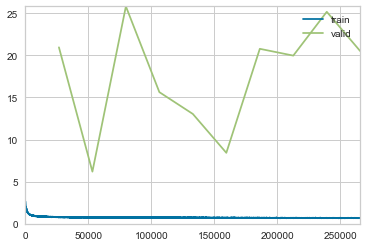

loss 20.499380111694336: accuracy: 63.35%



Time-based results
(2126364, 26)


epoch,train_loss,valid_loss,accuracy,time
0,0.962305,9.535914,0.461747,06:09
1,0.912511,29.155043,0.470101,06:08
2,0.912880,330.234497,0.534916,05:36
3,0.900448,174.752472,0.509149,05:40
4,0.889518,276.120605,0.489473,05:56
5,0.857626,460.150482,0.499882,06:52
6,0.862889,105.993301,0.485708,06:41
7,0.858649,235.371521,0.504569,05:43
8,0.837280,104.439804,0.483585,05:41
9,0.836863,155.497604,0.560420,04:51


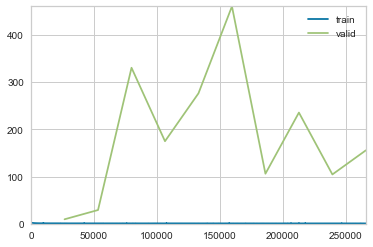

loss 155.4976043701172: accuracy: 56.04%


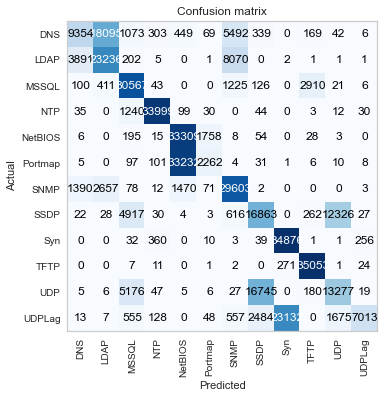

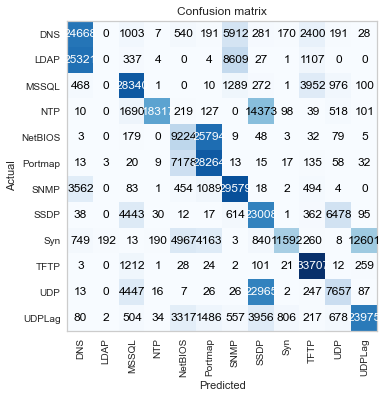

In [5]:
results = next(experiment)

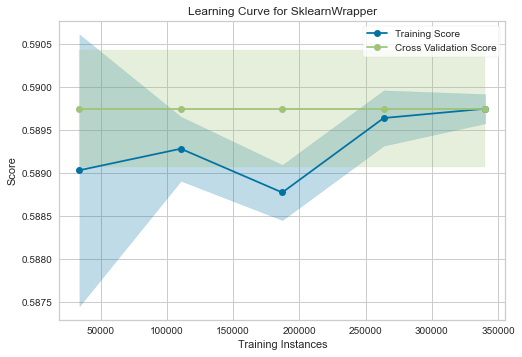

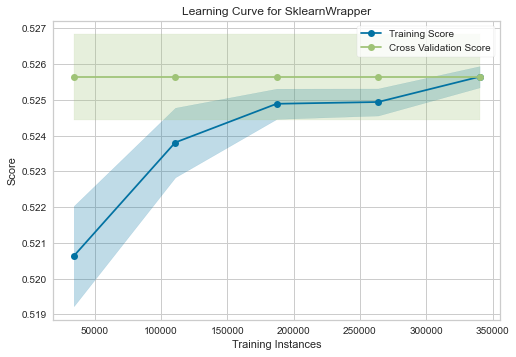

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


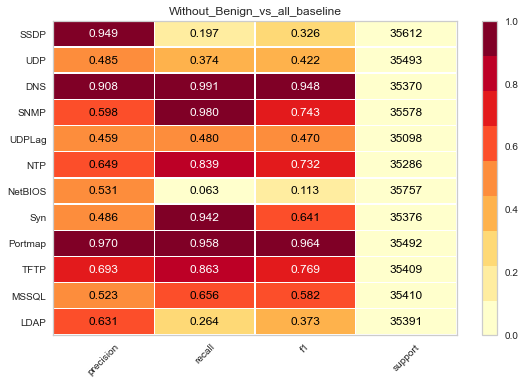

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


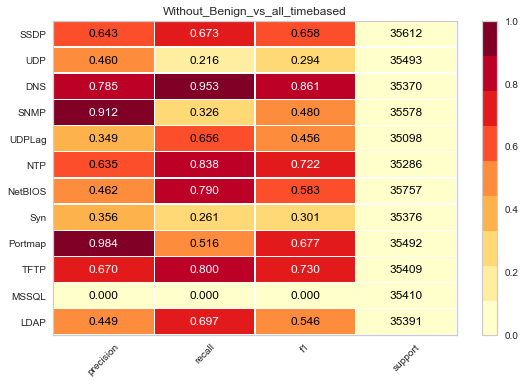

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


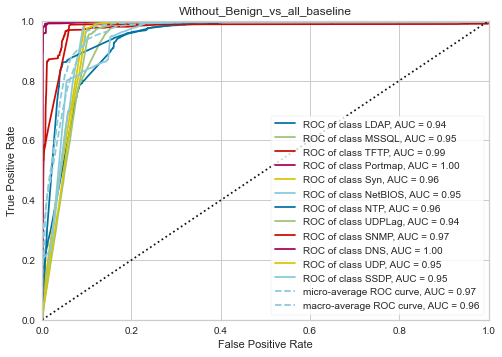

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


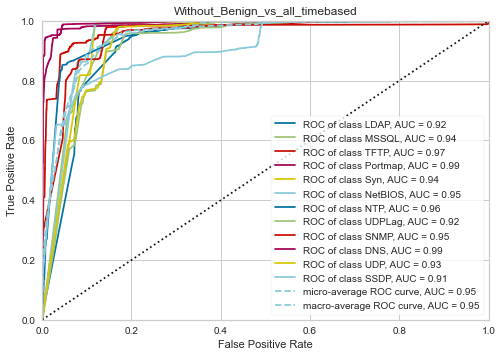

In [10]:
visualize_learning_curve_test(results[Baseline])
visualize_learning_curve_test(results[Timebased])
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_roc(results[Baseline])
visualize_roc(results[Timebased])

## Experiment #2: Multi-Class Classification with Benign Samples

Loading Dataset: ../data/prepared/baseline/Benign_Many_vs_Many.csv
	To Dataset Cache: ../data/cache/baseline/Benign_Many_vs_Many.csv.pickle

Loading Dataset: ../data/prepared/timebased/Benign_Many_vs_Many.csv
	To Dataset Cache: ../data/cache/timebased/Benign_Many_vs_Many.csv.pickle

Running experiment #2:	With_Benign
Baseline results
(1465503, 70)


epoch,train_loss,valid_loss,accuracy,time
0,0.742010,1.215207,0.622610,04:24
1,0.728083,2.313272,0.649014,05:14
2,0.704746,1.064241,0.639556,05:13
3,0.699822,5.215412,0.654111,04:50
4,0.685586,3.427487,0.650467,04:15
5,0.656132,3.434332,0.659983,04:11
6,0.665253,12.904331,0.650850,04:12
7,0.643158,3.221118,0.658236,04:14
8,0.629841,10.304142,0.654534,04:16
9,0.650530,0.783481,0.659389,04:17


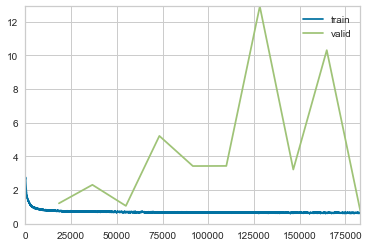

loss 0.783481240272522: accuracy: 65.94%



Time-based results
(1465503, 26)


epoch,train_loss,valid_loss,accuracy,time
0,1.066347,4.212193,0.440853,03:48
1,0.971969,2.982042,0.483814,03:47
2,0.919697,2.432207,0.505241,03:46
3,0.923690,1.760903,0.407383,04:11
4,0.897089,1.821026,0.434643,03:37
5,0.863547,9.342144,0.428506,03:33
6,0.874843,8.562769,0.470730,03:38
7,0.844575,7.853393,0.201552,03:47
8,0.826118,7.327223,0.469802,03:39
9,0.844002,1.769607,0.468335,03:39


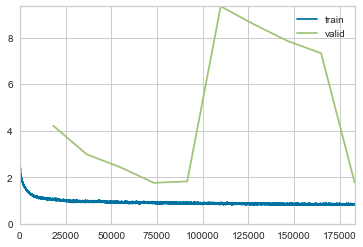

loss 1.7696071863174438: accuracy: 46.83%


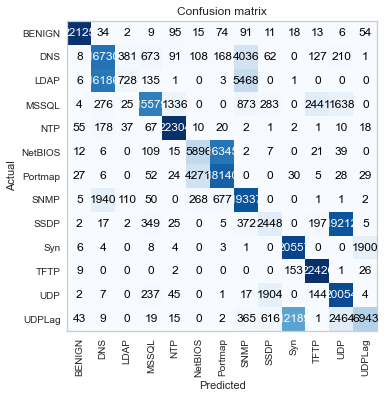

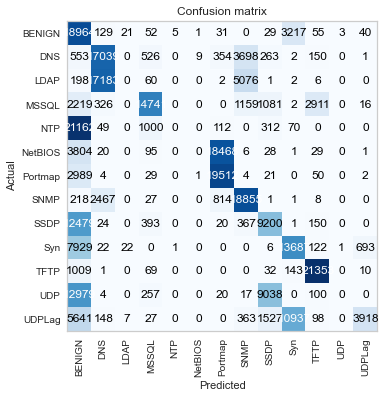

In [11]:
results = next(experiment)

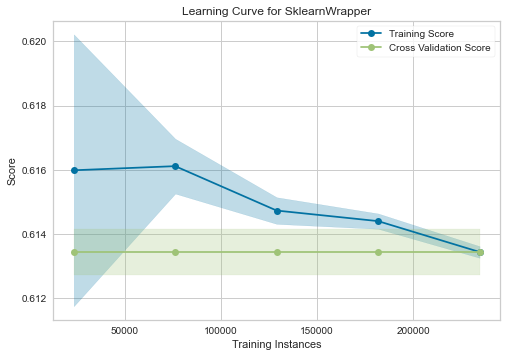

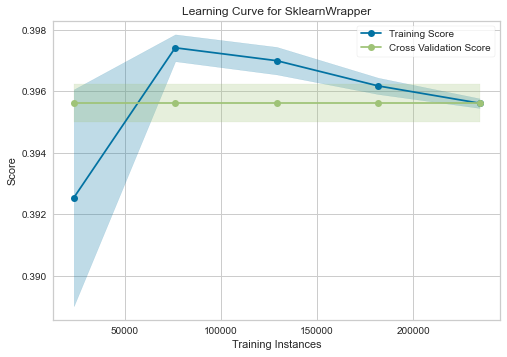

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


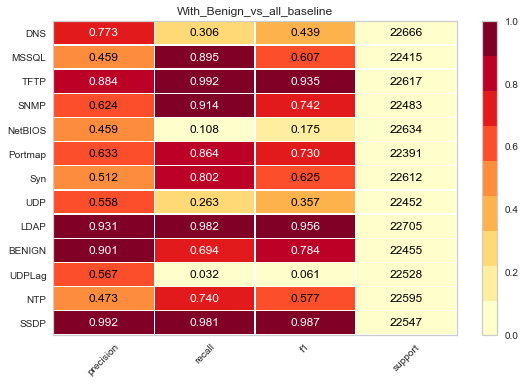

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


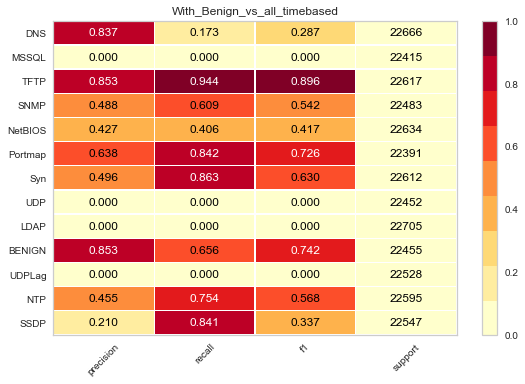

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


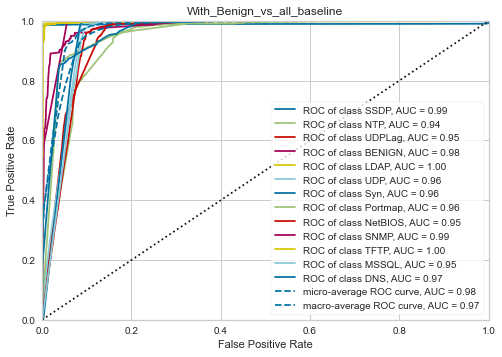

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


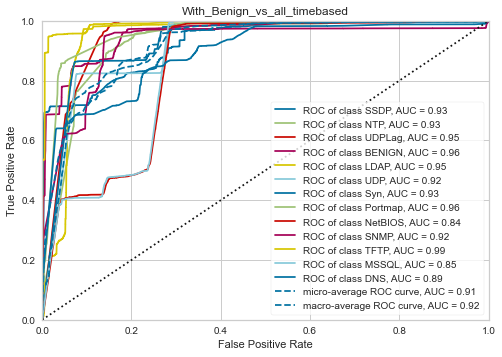

In [13]:
visualize_learning_curve_test(results[Baseline])
visualize_learning_curve_test(results[Timebased])
visualize_report(results[Baseline])
visualize_report(results[Timebased])
visualize_confusion_matrix(results[Baseline])
visualize_confusion_matrix(results[Timebased])
visualize_roc(results[Baseline])
visualize_roc(results[Timebased])